In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr

import pandas as pd
import cst
import pyaldata

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context("talk")

In [2]:
color_names = [
    "windows blue",
    "faded green",
    "orange",
    "amber",
    "dusty purple",
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = False

[(0.21568627450980393, 0.47058823529411764, 0.7490196078431373),
 (0.4823529411764706, 0.6980392156862745, 0.4549019607843137),
 (0.9764705882352941, 0.45098039215686275, 0.023529411764705882),
 (0.996078431372549, 0.7019607843137254, 0.03137254901960784),
 (0.5098039215686274, 0.37254901960784315, 0.5294117647058824)]

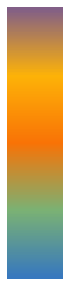

In [3]:
a=np.outer(np.arange(0,1,0.01),np.ones(10))
plt.figure(figsize=(1,5))
plt.axis("off")
plt.imshow(a,aspect='auto',cmap=cmap,origin="lower")
colors

In [4]:
# filename = '/data/raeed/project-data/smile/cst-gainlag/library/python/Ford_20180618_COCST_TD.mat'
filename = '/mnt/c/Users/Raeed/data/project-data/smile/cst-gainlag/library/python/Ford_20180618_COCST_TD.mat'
# td = cst.get_cst_dataframe(filename)
td = pyaldata.mat2dataframe(filename,True,'td_cst')
td.set_index('trial_id',inplace=True)

  0%|          | 0/50 [00:00<?, ?it/s]

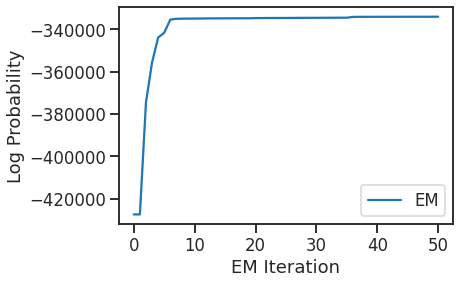

In [5]:
N_iters = 50
num_states = 4
obs_dim = 1
input_dims = 3

lambda_to_use = 3.3
td_lambda = td[td['lambda']==lambda_to_use]
# td_lambda = td
# control_obs = [el[:,0][:,None] for el in td_lambda['hand_vel']]
control_obs = [el[:,0][:,None] for el in td_lambda['hand_vel']]
vis_input = [np.column_stack((pos[:,0],vel[:,0],hand_pos[:,0]))
            for pos,vel,hand_pos in zip(td_lambda['cursor_pos_shift'],td_lambda['cursor_vel_shift'],td_lambda['hand_pos'])]

# hand_vel = A_{z_t}*(hand_vel_{t-1}) + V_{z_t}*[cursor_pos_shift;cursor_vel_shift;hand_pos] + \omega

hmm = ssm.HMM(num_states, obs_dim, M=input_dims, observations="input_driven_gaussian",transitions='recurrent_only')
# hmm = ssm.HMM(num_states, obs_dim, M=input_dims, observations="autoregressive",transitions='recurrent_only',observation_kwargs=dict(l2_penalty_A=1e10))

hmm_lls = hmm.fit(control_obs, inputs=vis_input, method="em", num_iters=N_iters, init_method="kmeans") #can also use random for initialization method, which sometimes works better

# make plots
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# permute states to keep things consistent
hmm.permute([2,1,0])

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(6,6))
all_hand_vel = np.row_stack(control_obs)
ax.hist(
    all_hand_vel,
    bins=np.linspace(-75,75,30),
    color='k')
sns.despine()

In [6]:
from ipywidgets import interact

@interact(trial_id=list(td_lambda.index),scale=(10,60),color_by_state=False)
def plot_cst_trial(trial_id,scale,color_by_state):
    trial = td_lambda.loc[trial_id,:]
    data = trial['hand_vel'][:,0][:,None]
    inpt = np.column_stack((trial['cursor_pos_shift'][:,0],trial['cursor_vel_shift'][:,0],trial['hand_pos'][:,0]))
    
    # Plot the true and inferred discrete states
    hmm_z = hmm.most_likely_states(data,input=inpt)
    posterior_probs = hmm.expected_states(data=data, input=inpt)[0]

    # old way
    plt.figure(figsize=(5,5))
    ax1 = plt.subplot(2,1,1)
    plt.plot([0,6],[0,0],'-k')
    plt.plot(trial['trialtime'],trial['cursor_pos'][:,0],'-b')
    plt.plot(trial['trialtime'],trial['hand_pos'][:,0],'-r')
    plt.xlim(0,6)
    plt.xticks([])
    plt.ylim(-scale,scale)
    plt.ylabel('Cursor or hand position')
    plt.title('$\lambda = {}$'.format(trial['lambda']))
    sns.despine()
    
    plt.subplot(212,sharex=ax1)
    for k in range(num_states):
        plt.plot(trial['trialtime'],posterior_probs[:, k], label="State " + str(k + 1), lw=2,
             color=colors[k])
    plt.ylim((-0.01, 1.01))
    plt.yticks([0, 0.5, 1], fontsize = 10)
    plt.xlim(0,6)
    plt.xlabel('Time (s)')
    plt.ylabel("p(state)", fontsize = 15)
    sns.despine()
    
    plt.figure(figsize=(5,10))
    plt.subplot(211)
    plt.plot([-60,60],[60,-60],'--k')
    plt.plot([0,0],[-60,60],'-k')
    plt.plot([-60,60],[0,0],'-k')
    if color_by_state:
        plt.scatter(
            trial['cursor_pos'][:,0],
            trial['hand_pos'][:,0],
            c=hmm_z,
            cmap=cmap,
            s=10,
            norm=mpl.colors.Normalize(vmin=0,vmax=len(color_names)-1)
        )
    else:
        plt.scatter(trial['cursor_pos'][:,0],trial['hand_pos'][:,0],c='k',s=10)
    plt.xlim(-scale,scale)
    plt.ylim(-scale,scale)
    plt.xlabel('Cursor pos')
    plt.ylabel('Hand pos')
    sns.despine()
    
#     plt.subplot(222)
#     plt.imshow(hmm_z[None,:],
#                aspect="auto",
#                cmap=cmap,
#                vmin=0,
#                vmax=len(colors)-1,
#                extent=(0, trial['bin_size']*trial['hand_pos'].shape[0], -scale, scale))
#     plt.plot(np.arange(0,trial['cursor_pos'].shape[0])*trial['bin_size'],trial['hand_pos'][:,0], '-k')
#     plt.xlim(0, trial['bin_size']*trial['hand_pos'].shape[0])
#     plt.xlabel("time")
#     plt.ylim(-scale,scale)
#     plt.tight_layout()
    
#     plt.subplot(223)
#     plt.imshow(hmm_z[:,None],
#                aspect="auto",
#                cmap=cmap,
#                vmin=0,
#                vmax=len(colors)-1,
#                extent=(-scale, scale, trial['bin_size']*trial['cursor_pos'].shape[0], 0))
#     plt.plot(trial['cursor_pos'][:,0],np.arange(0,trial['cursor_pos'].shape[0])*trial['bin_size'], '-k')
#     plt.ylim(0, trial['bin_size']*trial['hand_pos'].shape[0])
#     plt.ylabel("time")
#     plt.xlim(-scale,scale)
#     plt.tight_layout()
    
    plt.subplot(212)
    plt.plot([0,0],[-100,100],'-k')
    plt.plot([-60,60],[0,0],'-k')
    if color_by_state:
        plt.scatter(
            trial['cursor_pos_shift'][:,0],
            trial['cursor_vel_shift'][:,0],
            c=hmm_z,
            cmap=cmap,
            s=10,
            norm=mpl.colors.Normalize(vmin=0,vmax=len(color_names)-1)
        )
    else:
        plt.scatter(trial['cursor_pos_shift'][:,0],trial['cursor_vel_shift'][:,0],c='k',s=10)
    plt.xlim(-scale,scale)
    plt.ylim(-100,100)
    plt.xlabel('Delayed cursor pos')
    plt.ylabel('Delayed cursor vel')
    sns.despine()
    
    fig,ax = plt.subplots(num_states+1,1,figsize=(6,6),sharex=True,sharey=True)
    ax[0].hist(
        trial['hand_vel'][:,0],
        bins=np.linspace(trial['hand_vel'][:,0].min(),trial['hand_vel'][:,0].max(),30),
        color='k')
    for statenum in range(num_states):
        ax[statenum+1].hist(
            trial['hand_vel'][hmm_z==statenum,0],
            bins=np.linspace(trial['hand_vel'][:,0].min(),trial['hand_vel'][:,0].max(),30),
            color=colors[statenum])
        sns.despine()
        
    ax[0].set_title('Hand velocity distribution per state')
    ax[-1].set_xlabel('Hand velocity (mm/s)')
    ax[-1].set_ylabel('Number of 1 ms bins')

interactive(children=(Dropdown(description='trial_id', options=(151, 152, 153, 154, 155, 158, 159, 160, 161, 1…

In [ ]:
# Histogram of cursor/hand velocities during each state over all trials



In [ ]:
for i in range(num_states):
    plt.subplot(4,2,2*i+2)
    plt.imshow(hmm.observations.As[i],aspect='auto',cmap='RdBu',clim=[-1,1])
    if i==0:
        plt.title('Predicted')
    plt.ylabel('State'+str(i))


In [ ]:
dt = 1e-3
# print((hmm.observations.As-1)/dt)
# print(hmm.observations.As)
print(hmm.observations.bs)
print(hmm.observations.Vs)

In [ ]:
def plot_most_likely_dynamics(model,
    xlim=(-30, 30), ylim=(-100, 100), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors[k % len(colors)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

In [ ]:
print(hmm.transitions.Rs)
print(hmm.transitions.r)
print(hmm.transitions.Ws)

In [ ]:
hmm.transitions.transition_matrices(np.ones((3,1)),input=np.zeros((3,2)),mask=None,tag=None)

In [ ]:
for trial_id,trial in td_lambda.iterrows():
    cursor_pos = trial['cursor_pos_shift'][:,0]
    cursor_vel = trial['cursor_vel_shift'][:,0]
    hand_pos = trial['hand_pos'][:,0]
    norm_cursor_pos = np.sqrt(np.mean(cursor_pos**2))
    norm_cursor_vel = np.sqrt(np.mean(cursor_vel**2))
    norm_hand_pos = np.sqrt(np.mean(hand_pos**2))
    print(f"Cursor norm: {norm_cursor_pos}, {norm_cursor_vel}. Hand norm: {norm_hand_pos}")

In [ ]:
cursor_pos = td.loc[151,'cursor_pos']
cursor_vel = td.loc[151,'cursor_vel']

np.column_stack((cursor_pos[:,1],cursor_vel[:,1]))

In [ ]:
np.unique(td['lambda'])
lambda_to_use = 3.3
td_lambda = td[td['lambda']==lambda_to_use]
control_obs = [el[:,0][:,None] for el in td_lambda['hand_pos']]
vis_input = [np.column_stack((pos[:,0],vel[:,0]))
            for pos,vel in zip(td_lambda['cursor_pos_shift'],td_lambda['cursor_vel_shift'])]
for trial_id,trial in td_lambda.iterrows():
    display(trial)

In [19]:
list(range(0,100,30))

[0, 30, 60, 90]

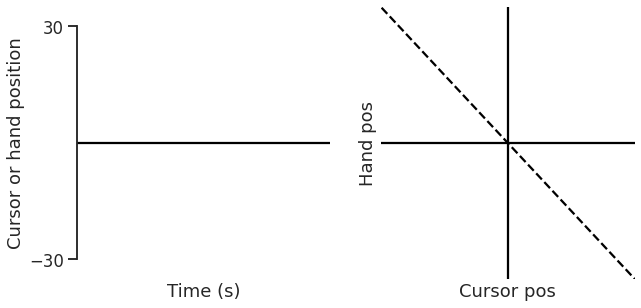

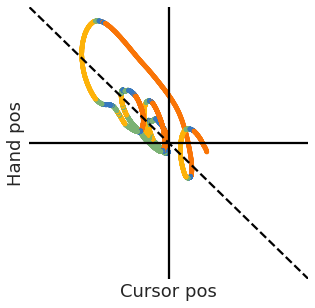

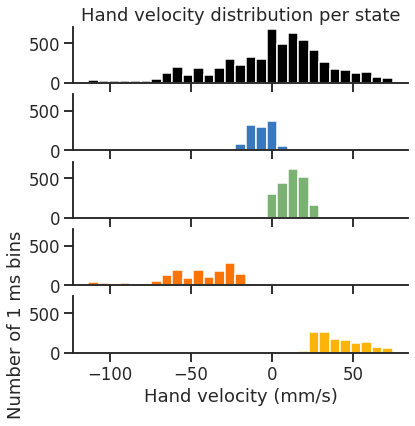

In [7]:
# Pick out specific trial
trial_id = 159
color_by_state=True
scale=35

trial = td_lambda.loc[trial_id,:]
data = trial['hand_vel'][:,0][:,None]
inpt = np.column_stack((trial['cursor_pos_shift'][:,0],trial['cursor_vel_shift'][:,0],trial['hand_pos'][:,0]))
hmm_z = hmm.most_likely_states(data,input=inpt)

# old fig + SM plots
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot([0,6],[0,0],'-k')
ax[0].set_xlim(0,6)
ax[0].set_ylim(-scale,scale)
ax[0].set_yticks([-30,30])
ax[0].set_xticks([])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Cursor or hand position')
sns.despine(ax=ax[0],left=False,bottom=True,trim=True)
ax[1].set_xlim(-scale,scale)
ax[1].set_ylim(-scale,scale)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].yaxis.tick_right()
ax[1].set_xlabel('Cursor pos')
ax[1].set_ylabel('Hand pos')
sns.despine(ax=ax[1],left=True,bottom=True)
ax[1].plot([-60,60],[60,-60],'--k')
ax[1].plot([0,0],[-60,60],'-k')
ax[1].plot([-60,60],[0,0],'-k')

cursor_l, = ax[0].plot([],[],'-b')
hand_l, = ax[0].plot([],[],'-r')
sm_l, = ax[1].plot([],[],'k',lw=4)

def animate_smplot(i):
    cursor_l.set_data(trial['trialtime'][:i],trial['cursor_pos'][:i,0])
    hand_l.set_data(trial['trialtime'][:i],trial['hand_pos'][:i,0])
    sm_l.set_data(trial['cursor_pos'][:i,0],trial['hand_pos'][:i,0])
    
ani = mpl.animation.FuncAnimation(
    fig=fig,
    func=animate_smplot,
    interval=30,
    frames=range(0,trial['trialtime'].shape[0],30),
    repeat=False
)

# from IPython.display import HTML
# HTML(ani.to_jshtml())

# anim_savename = r'/mnt/c/Users/Raeed/Wiki/professional/cabinet/talks/20210420-ncm2021/assets/Ford_20180618_CST_trial159_anim.mp4'
# writer = mpl.animation.FFMpegWriter(fps=30) 
# ani.save(anim_savename, writer=writer)
# animate_smplot(trial['trialtime'].shape[0])
# plt.savefig('/home/raeed/Wiki/smile/agendas/lab-meetings/presentations/smile/20210221/Ford_20180618_CST_old.pdf')

_,sm_ax = plt.subplots(1,1,figsize=(5,5))
sm_ax.plot([-60,60],[60,-60],'--k')
sm_ax.plot([0,0],[-60,60],'-k')
sm_ax.plot([-60,60],[0,0],'-k')
sm_ax.scatter(
    trial['cursor_pos'][:,0],
    trial['hand_pos'][:,0],
    c=hmm_z,
    cmap=cmap,
    s=10,
    norm=mpl.colors.Normalize(vmin=0,vmax=len(color_names)-1)
)
sm_ax.set_xticks([])
sm_ax.set_yticks([])
sm_ax.set_xlim(-scale,scale)
sm_ax.set_ylim(-scale,scale)
sm_ax.set_xlabel('Cursor pos')
sm_ax.set_ylabel('Hand pos')
sns.despine(ax=sm_ax,left=True,bottom=True)
plt.savefig(r'/mnt/c/Users/Raeed/Wiki/professional/cabinet/talks/20210420-ncm2021/assets/Ford_20180618_CST_trial159_smplot.pdf')

fig,ax = plt.subplots(num_states+1,1,figsize=(6,6),sharex=True,sharey=True)
ax[0].hist(
    trial['hand_vel'][:,0],
    bins=np.linspace(trial['hand_vel'][:,0].min(),trial['hand_vel'][:,0].max(),30),
    color='k')
for statenum in range(num_states):
    ax[statenum+1].hist(
        trial['hand_vel'][hmm_z==statenum,0],
        bins=np.linspace(trial['hand_vel'][:,0].min(),trial['hand_vel'][:,0].max(),30),
        color=colors[statenum])
    sns.despine()

ax[0].set_title('Hand velocity distribution per state')
ax[-1].set_xlabel('Hand velocity (mm/s)')
ax[-1].set_ylabel('Number of 1 ms bins')
plt.savefig(r'/mnt/c/Users/Raeed/Wiki/professional/cabinet/talks/20210420-ncm2021/assets/Ford_20180618_CST_trial159_handvelhist.pdf')